# Wine Clustering EDA 

This project aims to analise a dataset of chemical decomposition of wine samples from different wineries in Italy. (vinícolas) The analysis consists of using the **K-Means clustering algorithm** to distinguish different types of wines. The dataset is made up of **13 columns**:

* alcohol
* malic_acid
* ash
* alcalinity
* magnesium
* total_phenols
* flavanoids
* nonflavanoid_phenols
* proanthocyanins
* color_intensity
* hue
* 0D280_0D315_of_diluted_wines
* proline

The libraries used in this Machine Learning project are **Pandas, Seaborn and Scikit-Learn**. The chosen algorithm from the Scikit-Learn library is KMeans, although DBSCAN could be a useful alternative.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

## 1. Cleaning

To begin, we make a cleaning of the original files. The 'wine.names' file contains the description of the columns present in the dataset and other information, which is converted to a 'wine.txt' file. The 'wine.data' file is converted to tabular form 'wine.csv' by removing indices and adding a proper header.

In [2]:
# -- description of dataset

file = open('../input/wine-data/wine.names', mode='r')
data = file.read()

with open('../working/wine_description.txt', mode='w', encoding='utf8') as f:
  f.write(data)

# -- dataset

df = pd.read_csv('../input/wine-data/wine.data', sep=',')
df = df.drop(columns=df.columns[0], axis=1) # removing first column of indices

header = [
    'alcohol',
    'malic_acid',
    'ash',
    'alcalinity',
    'magnesium',
    'total_phenols',
    'flavanoids',
    'nonflavanoid_phenols',
    'proanthocyanins',
    'color_intensity',
    'hue',
    '0D280_0D315_of_diluted_wines',
    'proline'
]

df.columns = header
df.head()
df.to_csv('../working/wine.csv', sep=',', index=False)

## 2. Exploratory Data Analysis

As the dataset contains a great number of columns, we can use a heatmap to visualize the correlations between all the various data. This can be easily achieved by using Pandas DataFrame.corr() pairwise correlation function (gives DataFrame of values) and Seaborn sns.heatmap() function.

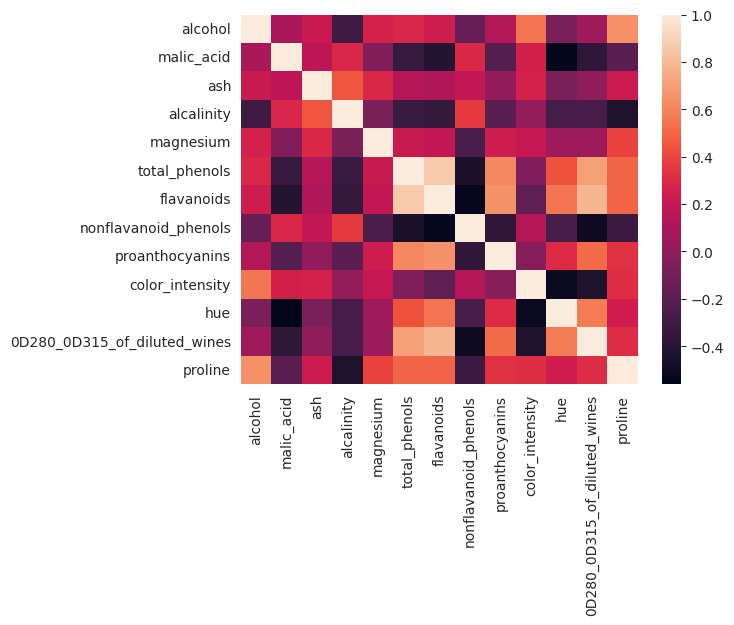

In [3]:
df = pd.read_csv('../working/wine.csv', sep=',')

with sns.axes_style('darkgrid'):
  grafico = sns.heatmap(df.corr(method='pearson'))

What can we deduce from this graph? We can see that the 'flavanoids' and 'total_phenols' columns have a high linear correlation between one another. A little less can be said about the relation between 'flavanoids' and '0D280_0D315_of_diluted_wines'.

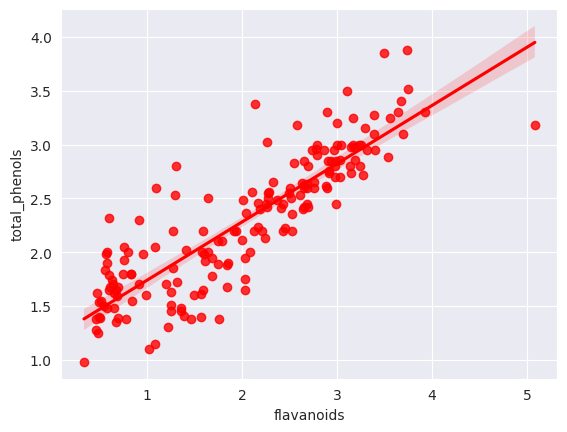

In [4]:
with sns.axes_style('darkgrid'):
    graph = sns.regplot(data=df, x=df['flavanoids'], y=df['total_phenols'], color='red')

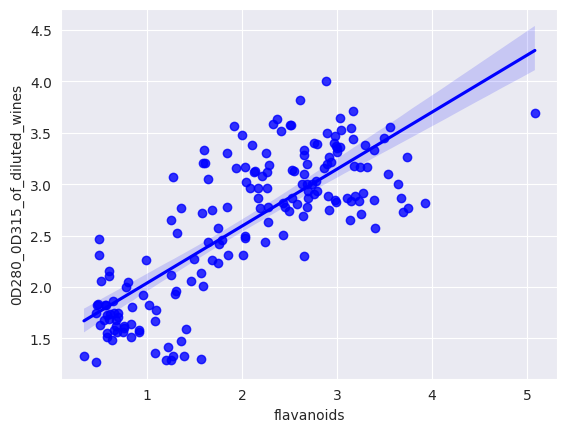

In [5]:
with sns.axes_style('darkgrid'):
    graph = sns.regplot(data=df, x=df['flavanoids'], y=df['0D280_0D315_of_diluted_wines'], color='blue')

## 3 - Machine Learning

### 3.1 - Normalization of data

We are going to save a copy of the original data. But, as the columns have pretty different scales of values, it is convenient to normalize the whole DataFrame. This ensures that the KMeans algorithm will not misbehave for outliers, or give inconsistent clustering.

In [6]:
df.head()

,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0D280_0D315_of_diluted_wines,proline
0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [7]:
df_original = df.copy()

for col in df.columns:
  df[col + '_norm'] = df[col].apply(lambda x: (x - df[col].min()) / (df[col].max() - df[col].min()))

df = df.drop(header, axis=1)
df.head()

,alcohol_norm,malic_acid_norm,ash_norm,alcalinity_norm,magnesium_norm,total_phenols_norm,flavanoids_norm,nonflavanoid_phenols_norm,proanthocyanins_norm,color_intensity_norm,hue_norm,0D280_0D315_of_diluted_wines_norm,proline_norm
0,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
1,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
2,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
3,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963
4,0.834211,0.201581,0.582888,0.237113,0.456522,0.789655,0.643460,0.396226,0.492114,0.466724,0.463415,0.578755,0.835949


### 3.2 - KMeans and WCSS

Now we apply the KMeans algorithm considering a range of k clusters going from 1 to 10, and calculate the **WCSS (Within Cluster Squared Sum)** as a measure of error to seek an ideal cluster number. With more clusters, this measure decreases in general, but after a certain number of clusters the decrease is not that significant.

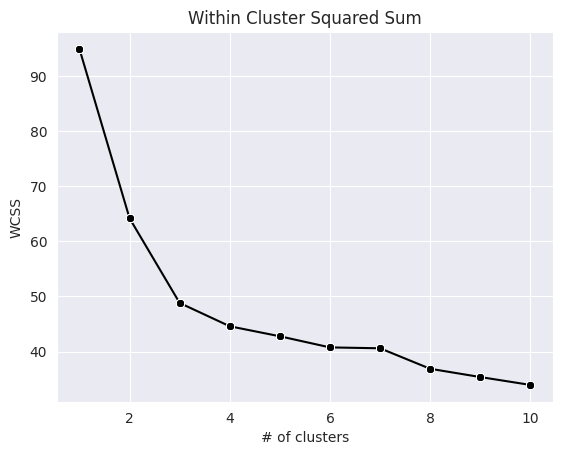

In [8]:
wcss = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, n_init='auto')
  model = model.fit(df)
  wcss.append(model.inertia_)

with sns.axes_style('darkgrid'):
  grafico = sns.lineplot(x=range(1, 11), y=wcss, marker='8', color='black')
  grafico.set(title='Within Cluster Squared Sum', xlabel='# of clusters', ylabel='WCSS')

We can see that after k = 3 the decrease in WCSS is small in comparison to the first computations. This is due to the *elbow method* which tells the optimal number of clusters is at the "elbow" of the graph.

### 3.3 - KMeans with k = 3

In [9]:
k = 3
model = KMeans(n_clusters=k, n_init='auto')
model = model.fit(df)
model.__dict__

{'n_clusters': 3,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'n_init': 'auto',
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'algorithm': 'lloyd',
 'feature_names_in_': array(['alcohol_norm', 'malic_acid_norm', 'ash_norm', 'alcalinity_norm',
        'magnesium_norm', 'total_phenols_norm', 'flavanoids_norm',
        'nonflavanoid_phenols_norm', 'proanthocyanins_norm',
        'color_intensity_norm', 'hue_norm',
        '0D280_0D315_of_diluted_wines_norm', 'proline_norm'], dtype=object),
 'n_features_in_': 13,
 '_tol': 4.124650784847455e-06,
 '_n_init': 1,
 '_algorithm': 'lloyd',
 '_n_threads': 4,
 'cluster_centers_': array([[0.3086163 , 0.23849292, 0.47584958, 0.49542734, 0.25490884,
         0.42096774, 0.35837757, 0.45100426, 0.37788745, 0.14243642,
         0.4686074 , 0.56085313, 0.16027794],
        [0.55371517, 0.50736263, 0.56558666, 0.54851425, 0.3115942 ,
         0.24273158, 0.10101762, 0.60747318, 0.23213954, 0.50808071,
         0.17232584, 0.15628816

> In this case, the fitted data contains the cluster informations in the 'labels_' which can be converted to a column to be added to the df_original DataFrame. This ensures now that the non-normalized values are matched with the cluster number.

In [10]:
clusters = model.labels_
clusters = pd.DataFrame(clusters, columns=['cluster'])

clustered_data = pd.concat([df_original, clusters], axis=1)
clustered_data.head()

,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0D280_0D315_of_diluted_wines,proline,cluster
0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2
2,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2
3,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2
4,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,2


> We can also convert the cluster values to strings to facilitate the use of Seaborn's boxplots over each cluster data.

In [11]:
names = {
    0: 'zero',
    1: 'one',
    2: 'two'
}

clustered_data['cluster'] = clustered_data['cluster'].apply(lambda x: names[x])
clustered_data.head()

,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0D280_0D315_of_diluted_wines,proline,cluster
0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,two
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,two
2,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,two
3,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,two
4,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,two


### 3.4 - Distributions and aggregations

> We can visualize, by cluster, the various distributions of the variables in each column of the DataFrame. For example, the cluster 'one' has the highest level of alcohol, cluster 'two' has the lowest level and cluster 'zero' has an intermediate amount.

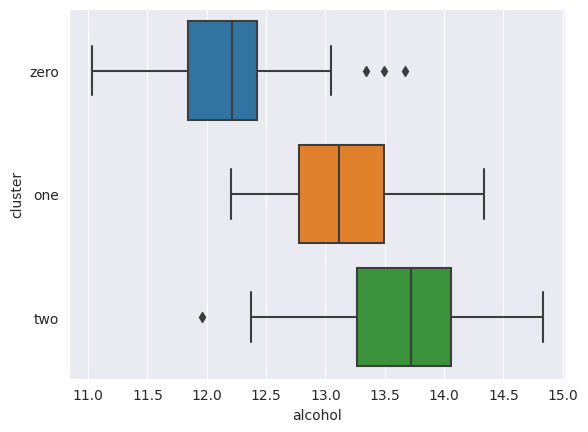

In [12]:
with sns.axes_style('darkgrid'):
  grafico = sns.boxplot(data=clustered_data, x=clustered_data['alcohol'], y=clustered_data['cluster'], order=['zero', 'one', 'two'])

> The **type one wine**, beyond having the **highest alcohol distribution**, also has the **highest flavanoid distribution** (which are linked to anti-oxidative and anti-inflammatory properties). This analysis can help to tell which wine variety has the highest quality.

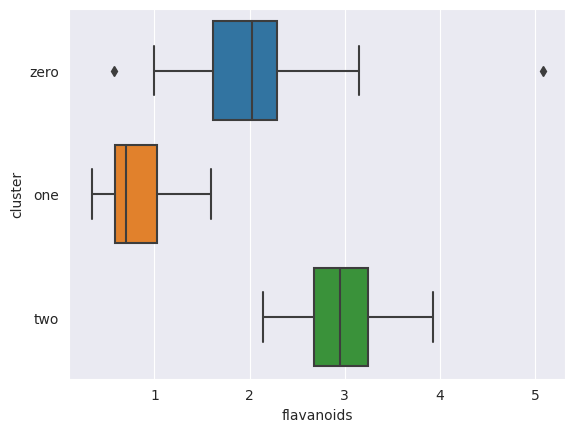

In [13]:
with sns.axes_style('darkgrid'):
  grafico = sns.boxplot(data=clustered_data, x=clustered_data['flavanoids'], y=clustered_data['cluster'], order=['zero', 'one', 'two'])

> Another analysis that can be done is to aggregate all the data by cluster. For example, we can obtain the mean and standard deviation of the values in each column, grouped by cluster number.

In [14]:
clustered_data.groupby(['cluster']).mean()

,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0D280_0D315_of_diluted_wines,proline
cluster,,,,,,,,,,,,,
one,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824
two,13.647969,1.949844,2.437813,17.470312,106.265625,2.865625,2.968594,0.284375,1.918125,5.357344,1.071875,3.136875,1080.343750
zero,12.202742,1.946774,2.249839,20.211290,93.451613,2.200806,2.038710,0.369032,1.607903,2.949355,1.056387,2.801129,502.709677


In [15]:
clustered_data.groupby(['cluster']).std()

,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0D280_0D315_of_diluted_wines,proline
cluster,,,,,,,,,,,,,
one,0.521855,1.093366,0.199023,2.408001,11.073693,0.349497,0.323911,0.123029,0.411335,2.345596,0.120383,0.274850,120.723554
two,0.552593,0.695928,0.246431,3.135242,13.634972,0.350355,0.418136,0.071844,0.432702,1.330424,0.122745,0.341183,250.322029
zero,0.497367,1.017681,0.319033,3.136203,14.190365,0.492565,0.678406,0.118137,0.576439,0.822678,0.203543,0.476029,136.022827


# 4. Conclusion

From this Machine Learning project we got **some insights** while dealing with a great number of columns to be clustered:

* From the KMeans algorithm the dataset was grouped in three different types of wines.
* In the dataset there is a strong correlation between 'flavanoids' and 'total_phenols' columns, and between 'flavanoids' and '0D280_0D315_of_diluted_wines' columns.
* Type one wine has the highest distribution of alcohol, whilst type zero wine has the lowest.
* The number of groups predicted by the elbow method with KMeans matches the number of types of wine identified in the 'wine_description.txt' file.